<a href="https://colab.research.google.com/github/Jvlia17/out-of-distribution-detection/blob/main/Detekcja_anomalii.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook poświęcony poznawaniu metod wyznaczania anomalii w danych (anomaly detection) oraz technik badania czy nowe dane pochodzą ze znanego rozkładu (novelty/out-of-distribution (OOD) detection).
Wykorzystywane metody wyznaczania anomalii:
- LOF,
- Isolation forest,
- odległość Mahalanobisa

# **Japanese Vowels dataset**

1456 points, 12 dimensions, 50 outliers (3.4%)   
https://odds.cs.stonybrook.edu/japanese-vowels-data/

## Pobranie danych

In [2]:
import numpy as np
from scipy.io import loadmat
data = loadmat('./data/vowels.mat')
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])


In [3]:
X = np.array(data.get('X')) # bez transpose
y = np.array(data.get('y')).ravel().astype(int)

In [4]:
# X zawiera obserwacje (wiersze) - cechy połączeń
# y - ocznaczenie połączeń jako ruch normalny (inlier) lub atak (outlier)

# print(X)
print(X.shape)
# print(y)
print(y.shape)  # 0 - inlier, 1 - outlier

(1456, 12)
(1456,)


## Analiza zbioru

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


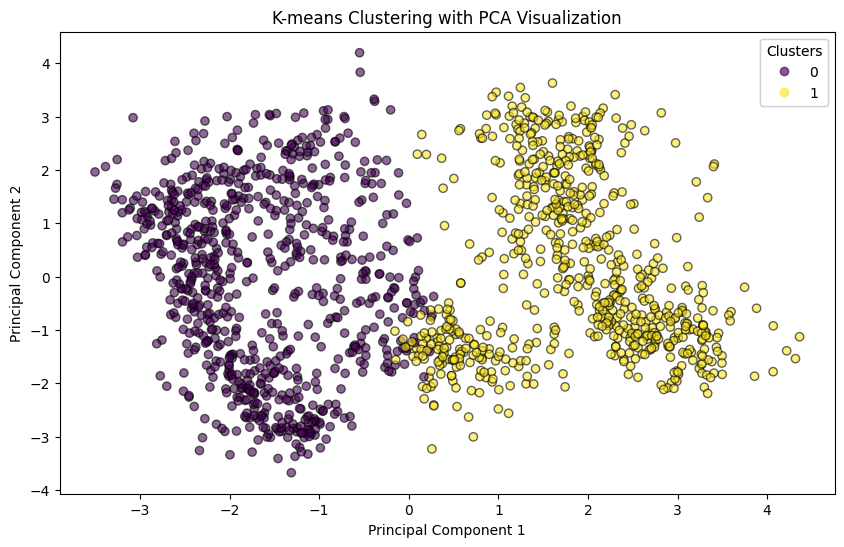

In [6]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Wybór liczby klastrów - może wymagać dostrojenia
n_clusters = 2

# Inicjalizacja i dopasowanie K-means do danych
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X)

# Przypisanie klastrów do danych
clusters = kmeans.labels_

# Redukcja wymiarowości za pomocą PCA dla celów wizualizacji
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Wykreślenie wyników klastrowania na wykresie 2D z użyciem PCA
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6, edgecolor='k')
plt.title('K-means Clustering with PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Dodanie legendy z etykietami klastrów
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

plt.show()


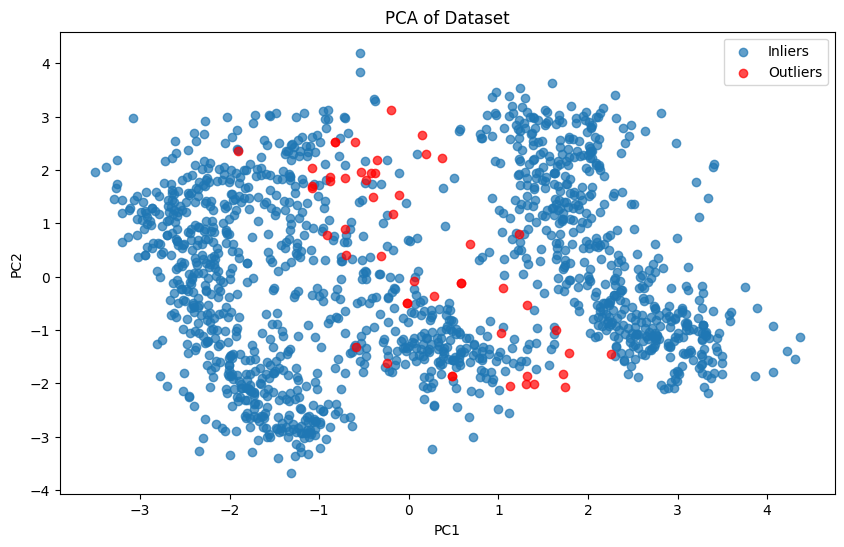

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Inicjalizacja PCA, redukcja do 2 głównych składowych
pca = PCA(n_components=2)

# Dopasowanie PCA do danych X i transformacja danych
X_pca = pca.fit_transform(X)

# Rozdzielanie przekształconych danych na inliers i outliers na podstawie y
X_pca_inliers = X_pca[y == 0]
X_pca_outliers = X_pca[y == 1]

# Wykreślenie wyników PCA
plt.figure(figsize=(10, 6))

# Inliers
plt.scatter(X_pca_inliers[:, 0], X_pca_inliers[:, 1], label='Inliers', alpha=0.7)

# Outliers
plt.scatter(X_pca_outliers[:, 0], X_pca_outliers[:, 1], label='Outliers', alpha=0.7, c='r')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Dataset')
plt.legend()
plt.show()


Wynik analizy zbioru: dzieląc zbiór na 2 klastry, outliers zdają się leżeć pomiędzy nimi

## LOF

In [19]:
from sklearn.neighbors import LocalOutlierFactor

model = LocalOutlierFactor(n_neighbors=35, novelty=False, contamination=0.034)
# model = LocalOutlierFactor(n_neighbors=35, novelty=False, contamination='auto')

y_pred = model.fit_predict(X)  # 1 - inlier, -1 - outlier

In [20]:
y_pred[y_pred==1] = 0    # inliers
y_pred[y_pred==-1] = 1   # outliers

In [21]:
print(np.array(np.unique(y, return_counts=True)))

print(np.array(np.unique(y_pred, return_counts=True)))

[[   0    1]
 [1406   50]]
[[   0    1]
 [1406   50]]


In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y, y_pred)

array([[1374,   32],
       [  32,   18]])

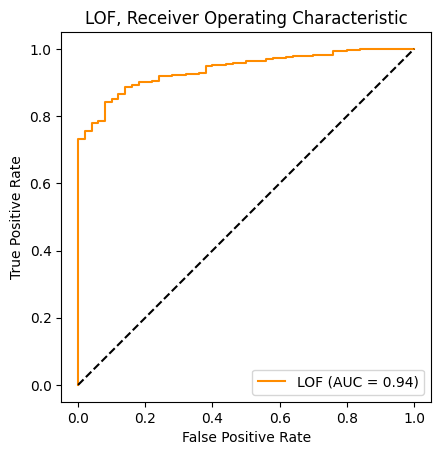

In [23]:
### plot ROC curve

import math
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

model.fit(X)
y_pred = model.negative_outlier_factor_


RocCurveDisplay.from_predictions(
    y,
    y_pred,
    name="LOF",
    color="darkorange",
    pos_label=0
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LOF, Receiver Operating Characteristic")
plt.legend()
plt.show()


## Isolation forest

In [30]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np

# Tworzenie modelu Isolation Forest
# iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
iso_forest = IsolationForest(n_estimators=100, contamination=0.034, random_state=42)

# Dopasowanie modelu do danych X
iso_forest.fit(X)

# Przewidywanie anomalii (wynik -1 dla anomalii, 1 dla normalnych punktów)
y_pred = iso_forest.predict(X)

In [31]:
y_pred[y_pred==1] = 0    # inliers
y_pred[y_pred==-1] = 1   # outliers

In [32]:
print(np.array(np.unique(y, return_counts=True)))

print(np.array(np.unique(y_pred, return_counts=True)))

[[   0    1]
 [1406   50]]
[[   0    1]
 [1406   50]]


In [33]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y, y_pred)

array([[1364,   42],
       [  42,    8]])

<Figure size 800x800 with 0 Axes>

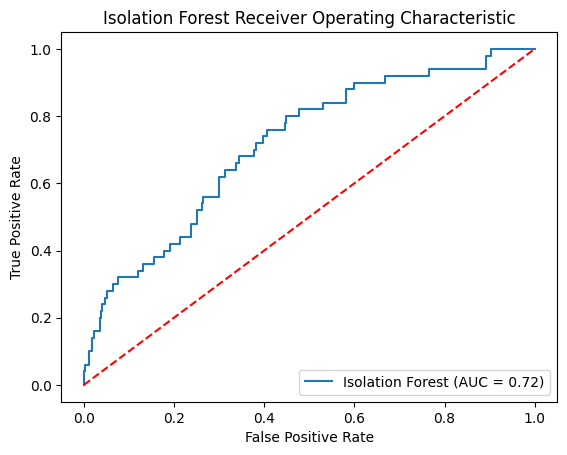

In [34]:
# Obliczenie wyników decyzyjnych za pomocą decision_function (alternatywnie można użyć score_samples)
scores = iso_forest.decision_function(X)

# Przewidywane etykiety binarne: 0 dla normalnych, 1 dla anomalii (konieczna zamiana -1 na 1)
y_pred_binary = (y_pred == -1).astype(int)

# Obliczanie krzywej ROC i AUC
# Uwaga: scores są odwrócone, więc używamy -scores, aby uzyskać poprawne wartości dla ROC
fpr, tpr, thresholds = roc_curve(y, -scores)
roc_auc = auc(fpr, tpr)

# Rysowanie krzywej ROC
plt.figure(figsize=(8, 8))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Isolation Forest').plot()
plt.plot([0, 1], [0, 1], linestyle='--', color='r')  # Linia referencyjna
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Isolation Forest Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

## Odległość Mahalanobisa

In [38]:
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Inicjalizacja modelu EllipticEnvelope z założeniem, że około 1% danych to anomalie
model = EllipticEnvelope(contamination=0.034, random_state=42)

# Dopasowanie modelu do danych
model.fit(X)

# Przewidywanie, czy punkt jest anomalią (-1 dla anomalii, 1 dla inlierów)
y_pred = model.predict(X)

In [39]:
y_pred[y_pred==1] = 0    # inliers
y_pred[y_pred==-1] = 1   # outliers

In [40]:
print(np.array(np.unique(y, return_counts=True)))

print(np.array(np.unique(y_pred, return_counts=True)))

[[   0    1]
 [1406   50]]
[[   0    1]
 [1406   50]]


In [41]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y, y_pred)

array([[1359,   47],
       [  47,    3]])

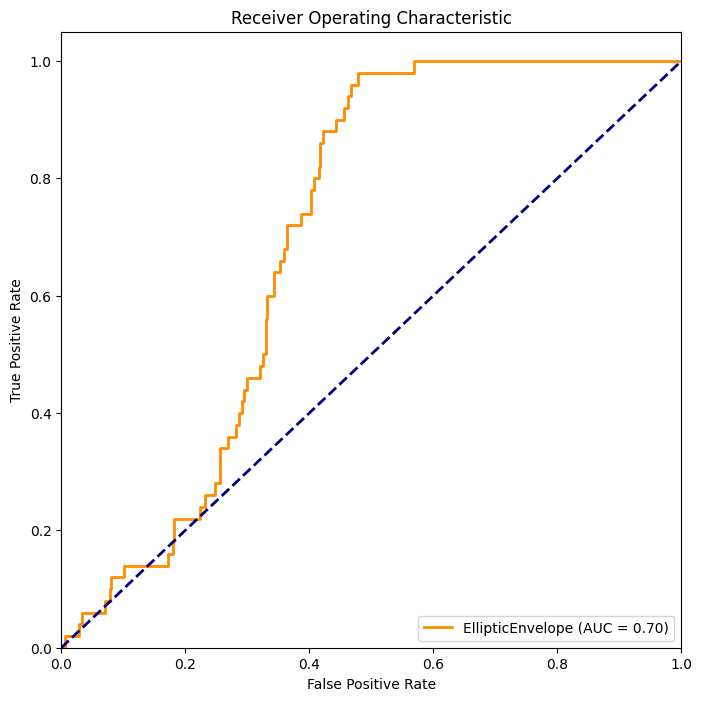

In [42]:
# Konwersja etykiet na 0 dla inlierów i 1 dla anomalii
y_pred = (y_pred == -1).astype(int)

# Obliczenie wyników decyzyjnych (odległość Mahalanobisa) dla ROC
# Funkcja decision_function zwraca wartości odwrotne od odległości Mahalanobisa
# Im większa wartość, tym bardziej punkt jest uznawany za anomalny
decision_function = model.decision_function(X)
# Wartości muszą być znormalizowane, aby mieć sens w kontekście ROC
scores = decision_function.max() - decision_function

# Tworzenie krzywej ROC
fpr, tpr, _ = roc_curve(y, scores)
roc_auc = auc(fpr, tpr)

# Rysowanie krzywej ROC
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='EllipticEnvelope (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# **Breast Cancer Wisconsin dataset**

683 points, 9 dimensions, 239 outliers (35%)   
https://odds.cs.stonybrook.edu/breast-cancer-wisconsin-original-dataset/

## Pobranie danych

In [43]:
import numpy as np
from scipy.io import loadmat
data = loadmat('./data/breastw.mat')
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])


In [44]:
X = np.array(data.get('X')) # bez transpose
y = np.array(data.get('y')).ravel().astype(int)

In [45]:
# X zawiera obserwacje (wiersze) - cechy połączeń
# y - ocznaczenie połączeń jako ruch normalny (inlier) lub atak (outlier)

# print(X)
print(X.shape)
# print(y)
print(y.shape)  # 0 - inlier, 1 - outlier

(683, 9)
(683,)


## Analiza zbioru

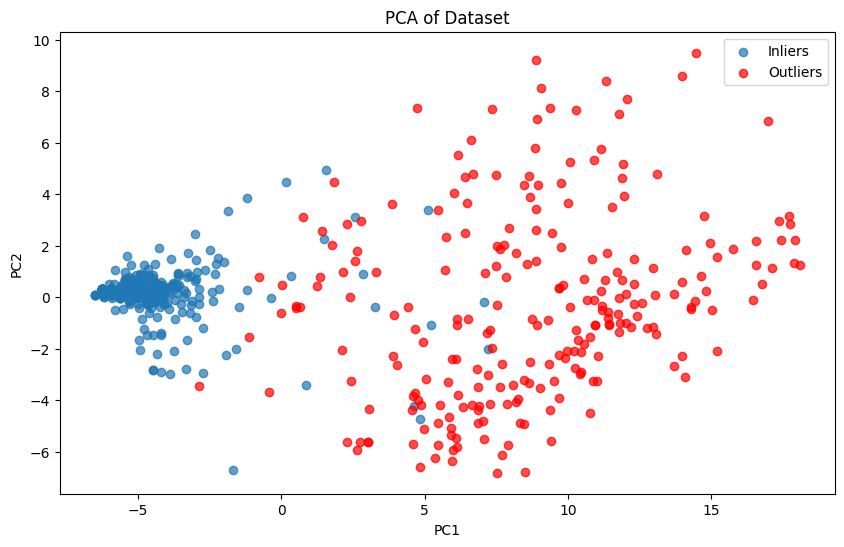

In [46]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Inicjalizacja PCA, redukcja do 2 głównych składowych
pca = PCA(n_components=2)

# Dopasowanie PCA do danych X i transformacja danych
X_pca = pca.fit_transform(X)

# Rozdzielanie przekształconych danych na inliers i outliers na podstawie y
X_pca_inliers = X_pca[y == 0]
X_pca_outliers = X_pca[y == 1]

# Wykreślenie wyników PCA
plt.figure(figsize=(10, 6))

# Inliers
plt.scatter(X_pca_inliers[:, 0], X_pca_inliers[:, 1], label='Inliers', alpha=0.7)

# Outliers
plt.scatter(X_pca_outliers[:, 0], X_pca_outliers[:, 1], label='Outliers', alpha=0.7, c='r')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Dataset')
plt.legend()
plt.show()


## LOF

In [52]:
from sklearn.neighbors import LocalOutlierFactor

# model = LocalOutlierFactor(n_neighbors=35, novelty=False, contamination='auto')
model = LocalOutlierFactor(n_neighbors=35, novelty=False, contamination=0.35)

y_pred = model.fit_predict(X)  # 1 - inlier, -1 - outlier

In [53]:
y_pred[y_pred==1] = 0    # inliers
y_pred[y_pred==-1] = 1   # outliers

In [54]:
print(np.array(np.unique(y, return_counts=True)))

print(np.array(np.unique(y_pred, return_counts=True)))

[[  0   1]
 [444 239]]
[[  0   1]
 [444 239]]


In [55]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y, y_pred)

array([[254, 190],
       [190,  49]])

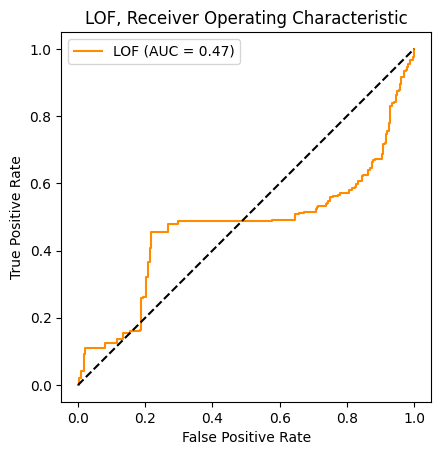

In [56]:
### plot ROC curve

import math
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

model.fit(X)
y_pred = model.negative_outlier_factor_


RocCurveDisplay.from_predictions(
    y,
    y_pred,
    name="LOF",
    color="darkorange",
    pos_label=0
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LOF, Receiver Operating Characteristic")
plt.legend()
plt.show()


## Isolation forest

In [60]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np

# Tworzenie modelu Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.35, random_state=42)

# Dopasowanie modelu do danych X
iso_forest.fit(X)

# Przewidywanie anomalii (wynik -1 dla anomalii, 1 dla normalnych punktów)
y_pred = iso_forest.predict(X)

In [61]:
y_pred[y_pred==1] = 0    # inliers
y_pred[y_pred==-1] = 1   # outliers

In [62]:
print(np.array(np.unique(y, return_counts=True)))

print(np.array(np.unique(y_pred, return_counts=True)))

[[  0   1]
 [444 239]]
[[  0   1]
 [444 239]]


In [63]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y, y_pred)

array([[426,  18],
       [ 18, 221]])

<Figure size 800x800 with 0 Axes>

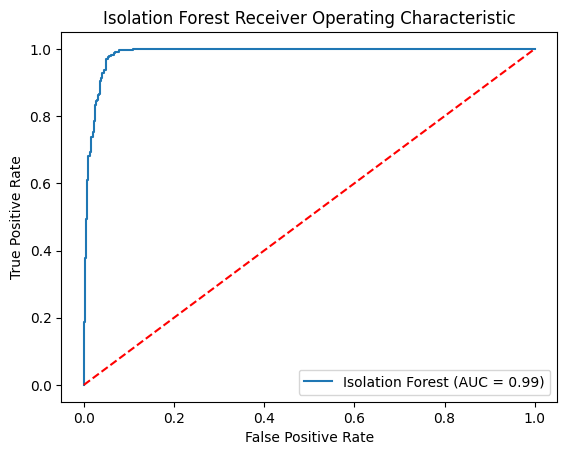

In [64]:
# Obliczenie wyników decyzyjnych za pomocą decision_function (alternatywnie można użyć score_samples)
scores = iso_forest.decision_function(X)

# Przewidywane etykiety binarne: 0 dla normalnych, 1 dla anomalii (konieczna zamiana -1 na 1)
y_pred_binary = (y_pred == -1).astype(int)

# Obliczanie krzywej ROC i AUC
# Uwaga: scores są odwrócone, więc używamy -scores, aby uzyskać poprawne wartości dla ROC
fpr, tpr, thresholds = roc_curve(y, -scores)
roc_auc = auc(fpr, tpr)

# Rysowanie krzywej ROC
plt.figure(figsize=(8, 8))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Isolation Forest').plot()
plt.plot([0, 1], [0, 1], linestyle='--', color='r')  # Linia referencyjna
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Isolation Forest Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

## Odległość Mahalanobisa

In [66]:
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Inicjalizacja modelu EllipticEnvelope z założeniem, że około 1% danych to anomalie
model = EllipticEnvelope(contamination=0.35, random_state=42)

# Dopasowanie modelu do danych
model.fit(X)

# Przewidywanie, czy punkt jest anomalią (-1 dla anomalii, 1 dla inlierów)
y_pred = model.predict(X)

In [67]:
y_pred[y_pred==1] = 0    # inliers
y_pred[y_pred==-1] = 1   # outliers

In [68]:
print(np.array(np.unique(y, return_counts=True)))

print(np.array(np.unique(y_pred, return_counts=True)))

[[  0   1]
 [444 239]]
[[  0   1]
 [444 239]]


In [69]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y, y_pred)

array([[430,  14],
       [ 14, 225]])

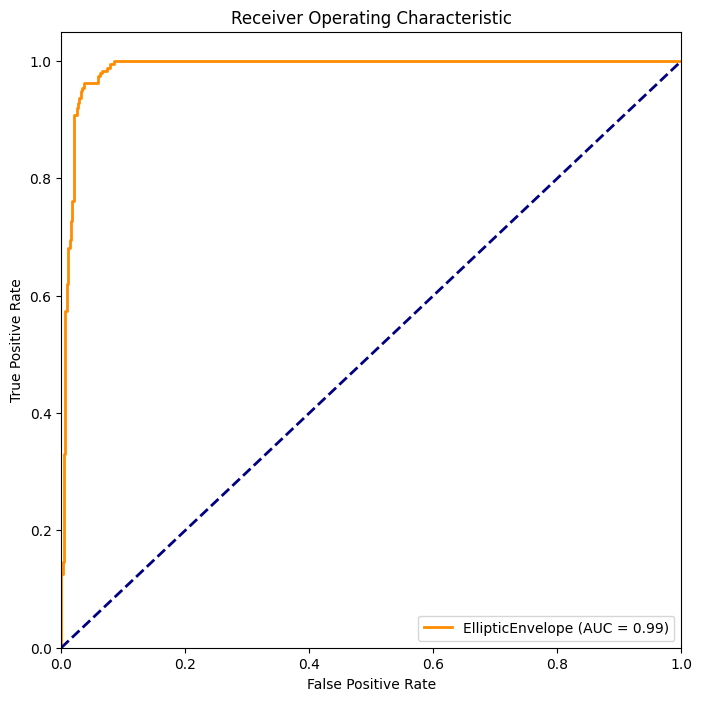

In [70]:
# Konwersja etykiet na 0 dla inlierów i 1 dla anomalii
y_pred = (y_pred == -1).astype(int)

# Obliczenie wyników decyzyjnych (odległość Mahalanobisa) dla ROC
# Funkcja decision_function zwraca wartości odwrotne od odległości Mahalanobisa
# Im większa wartość, tym bardziej punkt jest uznawany za anomalny
decision_function = model.decision_function(X)
# Wartości muszą być znormalizowane, aby mieć sens w kontekście ROC
scores = decision_function.max() - decision_function

# Tworzenie krzywej ROC
fpr, tpr, _ = roc_curve(y, scores)
roc_auc = auc(fpr, tpr)

# Rysowanie krzywej ROC
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='EllipticEnvelope (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# **Letter Recognition dataset**

1600 points, 32 dimensions, 100 outliers (6.25%)   
https://odds.cs.stonybrook.edu/letter-recognition-dataset/

## Pobranie danych

In [71]:
import numpy as np
from scipy.io import loadmat
data = loadmat('./data/letter.mat')
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])


In [72]:
X = np.array(data.get('X')) # bez transpose
y = np.array(data.get('y')).ravel().astype(int)

In [73]:
# X zawiera obserwacje (wiersze) - cechy połączeń
# y - ocznaczenie połączeń jako ruch normalny (inlier) lub atak (outlier)

# print(X)
print(X.shape)
# print(y)
print(y.shape)  # 0 - inlier, 1 - outlier

(1600, 32)
(1600,)


## Analiza zbioru

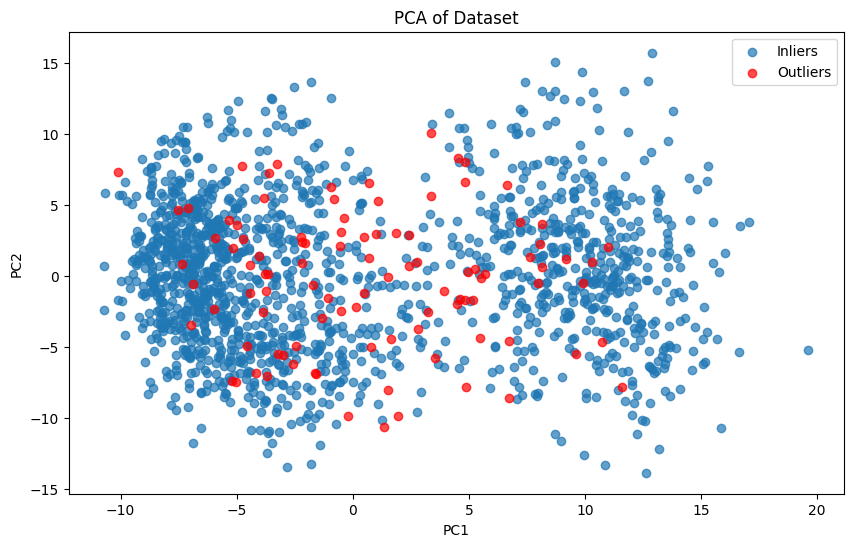

In [74]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Inicjalizacja PCA, redukcja do 2 głównych składowych
pca = PCA(n_components=2)

# Dopasowanie PCA do danych X i transformacja danych
X_pca = pca.fit_transform(X)

# Rozdzielanie przekształconych danych na inliers i outliers na podstawie y
X_pca_inliers = X_pca[y == 0]
X_pca_outliers = X_pca[y == 1]

# Wykreślenie wyników PCA
plt.figure(figsize=(10, 6))

# Inliers
plt.scatter(X_pca_inliers[:, 0], X_pca_inliers[:, 1], label='Inliers', alpha=0.7)

# Outliers
plt.scatter(X_pca_outliers[:, 0], X_pca_outliers[:, 1], label='Outliers', alpha=0.7, c='r')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Dataset')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


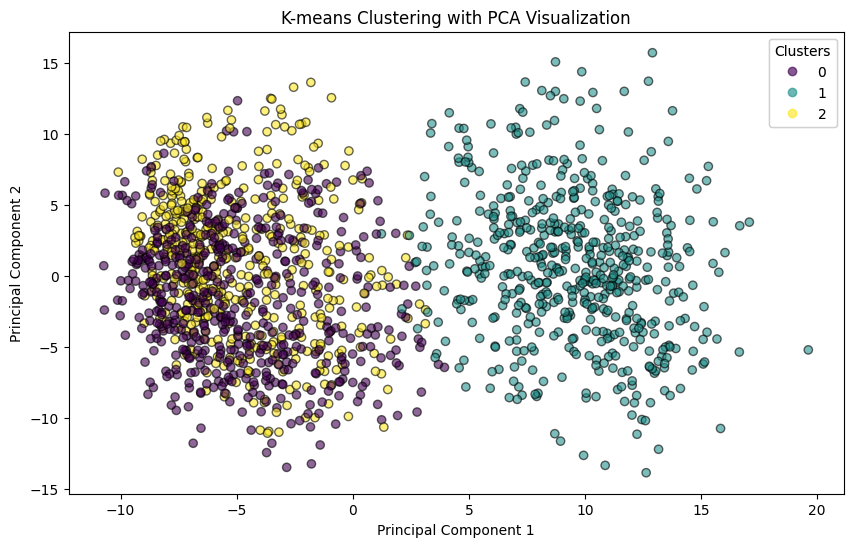

In [75]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Wybór liczby klastrów - może wymagać dostrojenia
n_clusters = 3

# Inicjalizacja i dopasowanie K-means do danych
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X)

# Przypisanie klastrów do danych
clusters = kmeans.labels_

# Redukcja wymiarowości za pomocą PCA dla celów wizualizacji
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Wykreślenie wyników klastrowania na wykresie 2D z użyciem PCA
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6, edgecolor='k')
plt.title('K-means Clustering with PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Dodanie legendy z etykietami klastrów
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

plt.show()


## LOF

In [77]:
from sklearn.neighbors import LocalOutlierFactor

model = LocalOutlierFactor(n_neighbors=35, novelty=False, contamination=0.0625)
# model = LocalOutlierFactor(n_neighbors=35, novelty=False, contamination=0.001)

y_pred = model.fit_predict(X)  # 1 - inlier, -1 - outlier

In [78]:
y_pred[y_pred==1] = 0    # inliers
y_pred[y_pred==-1] = 1   # outliers

In [79]:
print(np.array(np.unique(y, return_counts=True)))

print(np.array(np.unique(y_pred, return_counts=True)))

[[   0    1]
 [1500  100]]
[[   0    1]
 [1500  100]]


In [80]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y, y_pred)

array([[1442,   58],
       [  58,   42]])

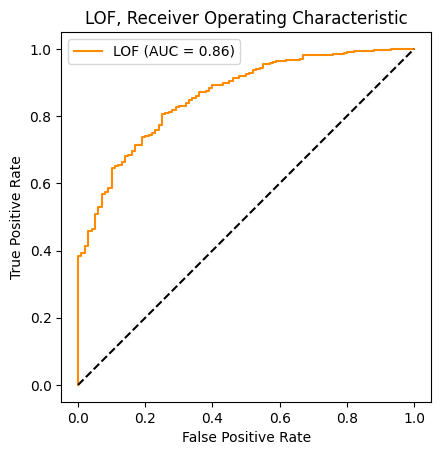

In [81]:
import math
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

model.fit(X)
y_pred = model.negative_outlier_factor_


RocCurveDisplay.from_predictions(
    y,
    y_pred,
    name="LOF",
    color="darkorange",
    pos_label=0
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LOF, Receiver Operating Characteristic")
plt.legend()
plt.show()


## Isolation forest

In [87]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np

# Tworzenie modelu Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.0625, random_state=42)

# Dopasowanie modelu do danych X
iso_forest.fit(X)

# Przewidywanie anomalii (wynik -1 dla anomalii, 1 dla normalnych punktów)
y_pred = iso_forest.predict(X)

In [88]:
y_pred[y_pred==1] = 0    # inliers
y_pred[y_pred==-1] = 1   # outliers

In [89]:
print(np.array(np.unique(y, return_counts=True)))

print(np.array(np.unique(y_pred, return_counts=True)))

[[   0    1]
 [1500  100]]
[[   0    1]
 [1500  100]]


In [90]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y, y_pred)

array([[1408,   92],
       [  92,    8]])

<Figure size 800x800 with 0 Axes>

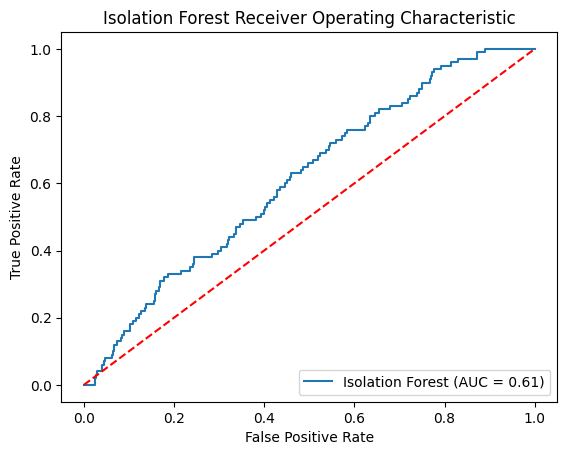

In [91]:
# Obliczenie wyników decyzyjnych za pomocą decision_function (alternatywnie można użyć score_samples)
scores = iso_forest.decision_function(X)

# Przewidywane etykiety binarne: 0 dla normalnych, 1 dla anomalii (konieczna zamiana -1 na 1)
y_pred_binary = (y_pred == -1).astype(int)

# Obliczanie krzywej ROC i AUC
# Uwaga: scores są odwrócone, więc używamy -scores, aby uzyskać poprawne wartości dla ROC
fpr, tpr, thresholds = roc_curve(y, -scores)
roc_auc = auc(fpr, tpr)

# Rysowanie krzywej ROC
plt.figure(figsize=(8, 8))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Isolation Forest').plot()
plt.plot([0, 1], [0, 1], linestyle='--', color='r')  # Linia referencyjna
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Isolation Forest Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

## Odległość Mahalanobisa

In [92]:
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Inicjalizacja modelu EllipticEnvelope z założeniem, że około 1% danych to anomalie
model = EllipticEnvelope(contamination=0.0625, random_state=42)

# Dopasowanie modelu do danych
model.fit(X)

# Przewidywanie, czy punkt jest anomalią (-1 dla anomalii, 1 dla inlierów)
y_pred = model.predict(X)

In [93]:
y_pred[y_pred==1] = 0    # inliers
y_pred[y_pred==-1] = 1   # outliers

In [94]:
print(np.array(np.unique(y, return_counts=True)))

print(np.array(np.unique(y_pred, return_counts=True)))

[[   0    1]
 [1500  100]]
[[   0    1]
 [1500  100]]


In [95]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y, y_pred)

array([[1417,   83],
       [  83,   17]])

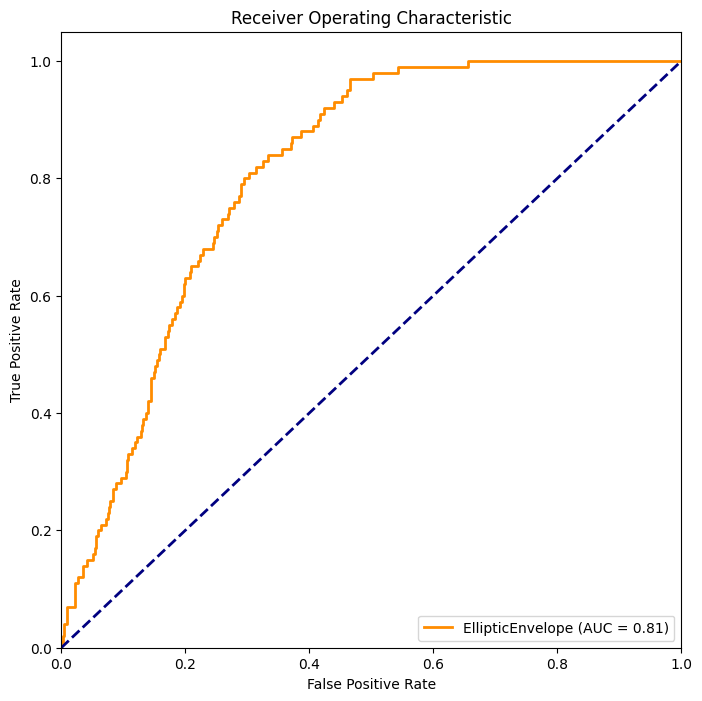

In [96]:
# Konwersja etykiet na 0 dla inlierów i 1 dla anomalii
y_pred = (y_pred == -1).astype(int)

# Obliczenie wyników decyzyjnych (odległość Mahalanobisa) dla ROC
# Funkcja decision_function zwraca wartości odwrotne od odległości Mahalanobisa
# Im większa wartość, tym bardziej punkt jest uznawany za anomalny
decision_function = model.decision_function(X)
# Wartości muszą być znormalizowane, aby mieć sens w kontekście ROC
scores = decision_function.max() - decision_function

# Tworzenie krzywej ROC
fpr, tpr, _ = roc_curve(y, scores)
roc_auc = auc(fpr, tpr)

# Rysowanie krzywej ROC
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='EllipticEnvelope (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
